# Model Training and Validation Pipeline
Now that you have created features, you can use them to train one or more models. In this section, you will generate feature vectors with multiple features from one or more feature sets and feed them into an automated ML training and testing pipeline to create high-quality models.

The ML pipeline can be triggered and tracked manually during the interactive devel‐ opment, or it can be saved (into Git) and be executed automatically on a given schedule or as a reaction to different events (such as code modification, CI/CD, data changes, model drift, and so on). See [MLRun project and CI/CD documentation](https://docs.mlrun.org/en/stable/projects/project.html) for details.


In [291]:
project_name = 'fraud-demo'

In [292]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-08-08 19:55:55,776 [info] Project loaded successfully: {'project_name': 'fraud-demo'}


In [293]:
project.set_function("hub://get_offline_features","get_vector",)
project.set_function("hub://feature_selection","feature-selection",)
project.set_function("hub://auto_trainer","train")
project.set_function("hub://auto_trainer","evaluate")
project.set_function("hub://v2_model_server", "serving")

Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing underscores with dashes.


In [337]:
# set project level parameters and save
project.spec.params = {'label_column': 'label'}
project.save()

In [338]:
print(project.to_yaml())

kind: project
metadata:
  name: fraud-demo-pengw
  created: '2023-08-04T18:02:33.655000'
spec:
  params:
    label_column: label
  functions:
  - url: hub://feature_selection
    name: feature-selection
  - url: hub://auto_trainer
    name: train
  - url: hub://v2_model_server
    name: serving
  - url: hub://get_offline_features
    name: get-vector
  - url: hub://auto_trainer
    name: evaluate
  workflows:
  - path: src/new_train_workflow.py
    name: main
  artifacts: []
  conda: ''
  source: git@github.com:pengwei715/demo-fraud.git#refs/heads/feature/align_with_book
  origin_url: git@github.com:pengwei715/demo-fraud.git#refs/heads/feature/align_with_book
  desired_state: online
  owner: pengw
  build:
    commands: []
    requirements: []
  custom_packagers: []
status:
  state: online



### Saving and loading projects from GIT

After you saved your project and its elements (functions, workflows, artifacts, etc.) you can commit all your changes to a 
GIT repository. This can be done using standard GIT tools or using MLRun `project` methods such as `pull`, `push`, 
`remote`, which calls the Git API for you.

Projects can then be loaded from Git using MLRun `load_project` method, for example: 

    project = mlrun.load_project("./myproj", "git://github.com/mlrun/project-demo.git", name=project_name)
    
or using MLRun CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-demo.git" ./myproj
    
Read [CI/CD integration](../../projects/ci-integration.html) for more details.

## Creating and Evaluating a Feature Vector

Models are trained with multiple features, which can arrive from different feature sets and be collected into training (feature) vectors. Feature stores know how to correctly combine the features into a vector by implementing smart JOINs and assessing the time dimension (time traveling).
To define a feature vector, you need to specify a name, the list of features it contains, the target features (labels), and other optional parameters. Features are specified as `<FeatureSet>.<Feature> or <FeatureSet>.*`  (all the features in a feature set). The following part demonstrates how to create and use a feature vector.


### Create a feature vector

In [339]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore

# Define the list of features to use
features = ['events.*',
            'transactions.amount_max_2h', 
            'transactions.amount_sum_2h', 
            'transactions.amount_count_2h',
            'transactions.amount_avg_2h', 
            'transactions.amount_max_12h', 
            'transactions.amount_sum_12h',
            'transactions.amount_count_12h', 
            'transactions.amount_avg_12h', 
            'transactions.amount_max_24h',
            'transactions.amount_sum_24h', 
            'transactions.amount_count_24h', 
            'transactions.amount_avg_24h',
            'transactions.es_transportation_sum_14d', 
            'transactions.es_health_sum_14d',
            'transactions.es_otherservices_sum_14d', 
            'transactions.es_food_sum_14d',
            'transactions.es_hotelservices_sum_14d', 
            'transactions.es_barsandrestaurants_sum_14d',
            'transactions.es_tech_sum_14d', 
            'transactions.es_sportsandtoys_sum_14d',
            'transactions.es_wellnessandbeauty_sum_14d', 
            'transactions.es_hyper_sum_14d',
            'transactions.es_fashion_sum_14d', 
            'transactions.es_home_sum_14d', 
            'transactions.es_travel_sum_14d', 
            'transactions.es_leisure_sum_14d',
            'transactions.gender_F',
            'transactions.gender_M',
            'transactions.step', 
            'transactions.amount', 
            'transactions.timestamp_hour',
            'transactions.timestamp_day_of_week']

### Create a feature vector

In [340]:
# Define the feature vector name for future reference
fv_name = 'transactions-fraud'

# Define the feature vector using the feature store (fstore)
transactions_fv = fstore.FeatureVector(fv_name, 
                          features, 
                          label_feature="labels.label",
                          description='Predicting a fraudulent transaction')

# Save the feature vector in the feature store
transactions_fv.save()

Once you have defined the feature vector, you can use `get_offline_features()` to generate the vector dataset and return it as a dataframe or materialize it into a file (CSV or Parquet). The next part demonstrates how to retrieve a vector, materialize it, and view its results.

## Building and Running an Automated Training and Validation Pipeline

MLRun allows the building of distributed ML pipelines that can handle data processing, automated feature selection, training, optimization, testing, deployments, and so on. Pipelines are composed of steps that run or deploy custom or library (from the MLRun hub) serverless functions. Pipelines can be run locally (for debugging or small-scale tasks), on a scalable Kubernetes cluster (using Kubeflow), or in a CI/CD system.

The example consists of the following pipeline steps (all using pre-defined MLRun hub functions):

1. Materialize a feature vector (using `hub://get_offline_features`). 
2. Select the most optimal features (using `hub://feature_selection`).
3. Train the model with multiple algorithms (using `hub://auto_trainer`).
4. Evaluate the model (using `hub://auto_trainer`).
5. Deploy the model and its application to the test cluster (using `hub://v2_model_server`). The next section will explain the model and application pipeline in detail.

Each step can accept the previous steps’ results or data, and generate results, multiple visual artifacts/charts, versioned data objects, and registered models.

### ML pipeline (data prep, train, validate, and deploy)

In [345]:
import mlrun
from kfp import dsl

from mlrun.model import HyperParamOptions


# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(name="Fraud Detection Pipeline",description="Detecting fraud from a transactions dataset",)
def pipeline( vector_name="transactions-fraud", features=[], label_column="is_error"):
    project = mlrun.get_current_project() # Get FeatureVector
    get_vector = mlrun.run_function(
        "hub://get_offline_features",
        name="get_vector",
        params={'feature_vector': vector_name,
        'features': features,
        'label_feature': label_column, 
        'target': {'name': 'parquet', 'kind': 'parquet'}, 
        "update_stats": True},
        outputs=["feature_vector"],
    )
    # Feature selection
    feature_selection = mlrun.run_function(
        "hub://feature_selection",
        name="feature-selection",
        params={
        "output_vector_name": "short",
        "label_column": project.get_param("label_column", "label"), "k": 18,
        "min_votes": 2,
        "ignore_type_errors": True,
        }, 
        inputs={"df_artifact": get_vector.outputs['feature_vector']},
        outputs=[
        "feature_scores",
        "selected_features_count",
        "top_features_vector",
        "selected_features",
        ], 
    )
    # train with hyper-paremeters
    train = mlrun.run_function(
        "hub://auto_trainer",
        name="train",
        handler="train",
        params={
            "sample": -1,
            "label_column": project.get_param("label_column", "label"),
            "test_size": 0.10,
        },
        hyperparams={
            "model_name": [
            "transaction_fraud_rf",
            "transaction_fraud_xgboost",
            "transaction_fraud_adaboost",
        ],
        "model_class": [
            "sklearn.ensemble.RandomForestClassifier",
            "sklearn.linear_model.LogisticRegression",
            "sklearn.ensemble.AdaBoostClassifier",
        ], 
        },
        hyper_param_options=HyperParamOptions(strategy="list",
                                          selector="max.accuracy"),
        inputs={"dataset": feature_selection.outputs["top_features_vector"]},
        outputs=["model", "test_set"],
    )
    # test and visualize your model
    test = mlrun.run_function(
        "hub://auto_trainer",
        name="evaluate",
        handler="evaluate",
        params={
            "label_columns": project.get_param("label_column", "label"),
            "model": train.outputs["model"],
            "drop_columns": project.get_param("label_column", "label"),
        },
        inputs={"dataset": train.outputs["test_set"]},
    )
    # Create a serverless function from the hub, add a feature enrichment router
    # This will enrich and impute the request with data from the feature vector
    serving_function = mlrun.import_function("hub://v2_model_server",
                                             new_name="serving")
    serving_function.set_topology(
        "router",
        mlrun.serving.routers.EnrichmentModelRouter( feature_vector_uri="short", impute_policy={"*": "$mean"}), exist_ok=True
    )
    # Enable model monitoring
    serving_function.set_tracking()
    serving_function.save()
    # deploy the model server, pass a list of trained models to serve
    deploy = mlrun.deploy_function(
        serving_function,
        models=[{"key": "fraud", "model_path": train.outputs["model"]}],
    )

The workflow/pipeline can be executed using the MLRun SDK (`project.run()` method) or using CLI commands (mlrun project), and can run directly from the source repo (GIT). See details in [MLRun Projects and Automation documentation](https://docs.mlrun.org/en/stable/projects/project.html).

You can set arguments and destinations for the different artifacts when you run the workflow. The pipeline progress and results are shown in the notebook. Alternatively, you can check the progress, logs, artifacts, and more, in the MLRun UI or the CI/CD system. The next part demonstrates how to run the pipeline with custom arguments using the SDK.

In [346]:
# Register the workflow file as "main"
project.set_workflow('main', 'src/new_train_workflow.py')
project.save()

## Running the ML pipeline

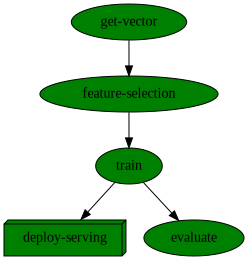

uid,start,state,name,parameters,results
...54adf990,Aug 08 21:58:29,completed,evaluate,label_columns=labelmodel=store://artifacts/fraud-demo-pengw/transaction_fraud_rf:e42ef62b-8c38-4c40-bf2a-baf6e3403c7bdrop_columns=label,evaluation_accuracy=0.992503748125937evaluation_f1_score=0.4444444444444444evaluation_precision_score=0.5454545454545454evaluation_recall_score=0.375
...4e74d20d,Aug 08 21:57:43,completed,train,sample=-1label_column=labeltest_size=0.1,best_iteration=1accuracy=0.992503748125937f1_score=0.4444444444444444precision_score=0.5454545454545454recall_score=0.375
...b26fa2c8,Aug 08 21:57:13,completed,feature-selection,output_vector_name=shortlabel_column=labelk=18min_votes=2ignore_type_errors=True,top_features_vector=store://feature-vectors/fraud-demo-pengw/short
...6de3a680,Aug 08 21:56:53,completed,get-vector,"feature_vector=transactions-fraudfeatures=[]label_feature=labels.labeltarget={'name': 'parquet', 'kind': 'parquet'}update_stats=True",feature_vector=transactions-fraudfeature_vector_uri=store://feature-vectors/fraud-demo-pengw/transactions-fraud:latest


In [355]:
run_id = project.run(
    'main',
    arguments={'vector_name':"transactions-fraud",
                'label_column':"labels.label",
              }, 
    dirty=True, watch=True)

![UI - WorkFlow](images/pipline-ui.png)

## Test the model endpoint


Now that your model is deployed using the pipeline, you can invoke it as usual:

In [356]:
# Define your serving function
serving_fn = project.get_function('serving')

# Choose an id for your test
sample_id = 'C1000148617'
model_inference_path = '/v2/models/fraud/infer'

# Send our sample ID for predcition
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2023-08-08 22:00:01,010 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-fraud-demo-pengw-serving.default-tenant.svc.cluster.local:8080/v2/models/fraud/infer'}


{'id': 'db83101d-aa69-47a7-9056-089141ca0b54',
 'model_name': 'fraud',
 'outputs': [0]}

## Done!

You've completed Part 4 of the model training with the feature store.
Proceed to part 5 to learn how to deploy real-time application pipeline